Text(0, 0.5, 'Output')

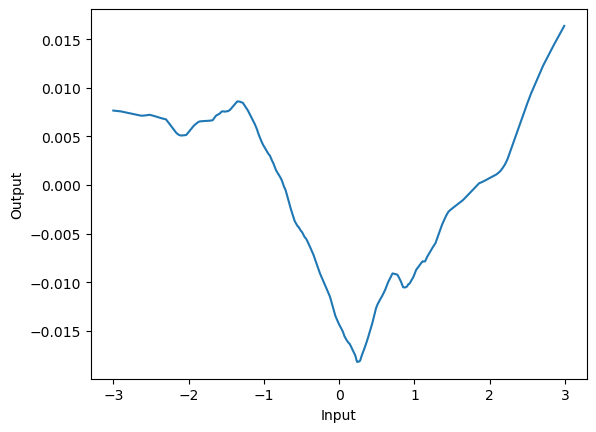

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
model = nn.Sequential(nn.Linear(1,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,1))
opt = optim.SGD(model.parameters(),lr=1e-2)
for _ in range(100):
    loss = nn.MSELoss()(model(torch.randn(100,1)), torch.randn(100,1))
    opt.zero_grad()
    loss.backward()
    opt.step()
                      
plt.plot(np.arange(-3,3,0.01), model(torch.arange(-3,3,0.01)[:,None]).detach().numpy())
plt.xlabel("Input")
plt.ylabel("Output")


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,10)).to(device)

model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)


4.6%

100.0%


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw


100.0%


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw




4.0%

100.0%


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



100.0%

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw


In [6]:
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


In [7]:
opt = optim.SGD(model_dnn_2.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_2, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_2)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.132383	0.517379	0.082800	0.293092
0.075733	0.264427	0.063200	0.223533
0.059050	0.209196	0.053000	0.183827
0.048500	0.172277	0.046500	0.156950
0.041267	0.146381	0.042100	0.140970
0.035433	0.127160	0.037200	0.123632
0.031550	0.112089	0.033400	0.113063
0.027900	0.100130	0.031800	0.104656
0.024683	0.091016	0.030100	0.102957
0.023167	0.082945	0.028400	0.095720


In [8]:
opt = optim.SGD(model_dnn_4.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_4, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_4)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")


0.234450	0.779161	0.078200	0.272548
0.064300	0.218654	0.049800	0.159486
0.042250	0.142899	0.039500	0.125869
0.031750	0.107084	0.030700	0.099758
0.024933	0.085170	0.030500	0.096979
0.020250	0.068135	0.026400	0.083797
0.017200	0.056607	0.026400	0.080332
0.014750	0.047070	0.025100	0.078598
0.011783	0.039624	0.023600	0.072337
0.010400	0.033539	0.022200	0.073599


In [9]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")


0.211100	0.627654	0.026200	0.084529
0.023933	0.078012	0.015500	0.048904
0.016867	0.053632	0.014500	0.046713
0.012783	0.039703	0.014800	0.046389
0.008583	0.028416	0.013400	0.036891
0.004083	0.013596	0.011000	0.032329
0.002983	0.010686	0.011600	0.032505
0.002333	0.009418	0.010800	0.032946
0.002183	0.008492	0.011400	0.033206
0.001883	0.007684	0.011200	0.033991


In [ ]:
torch.save(model_dnn_2.state_dict(), "model_dnn_2.pt")
torch.save(model_dnn_4.state_dict(), "model_dnn_4.pt")
torch.save(model_cnn.state_dict(), "model_cnn.pt")


In [ ]:
model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))
model_dnn_4.load_state_dict(torch.load("model_dnn_4.pt"))
model_cnn.load_state_dict(torch.load("model_cnn.pt"))


In [10]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()


In [11]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()


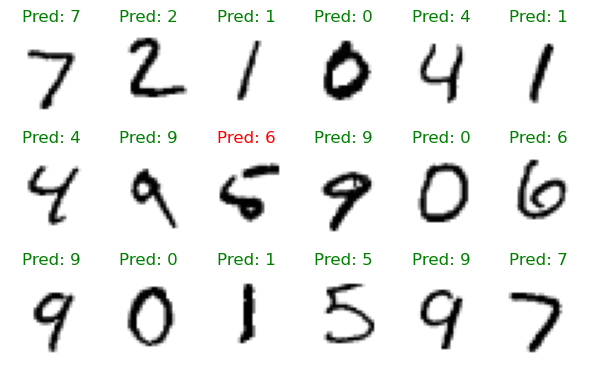

In [12]:
### Illustrate original predictions
yp = model_dnn_2(X)
plot_images(X, y, yp, 3, 6)


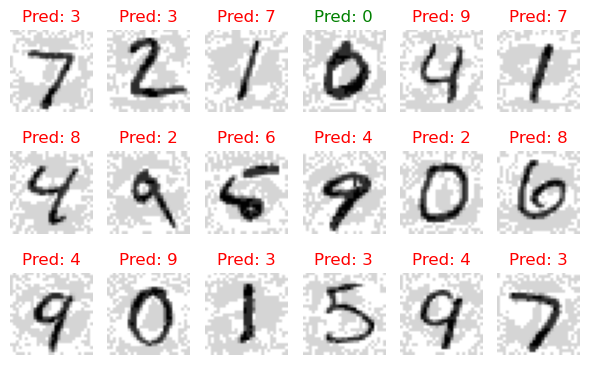

In [13]:
### Illustrate attacked images
delta = fgsm(model_dnn_2, X, y, 0.1)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)


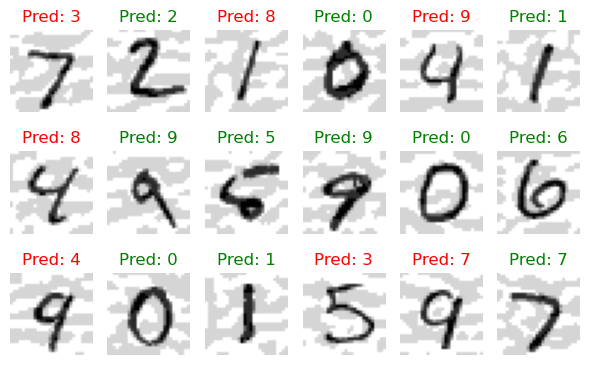

In [14]:
### Illustrate attacked images
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)


In [15]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


In [16]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.1)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.1)[0])
print("        CNN:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])


2-layer DNN: 0.9133
4-layer DNN: 0.9343
        CNN: 0.4328


In [17]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()


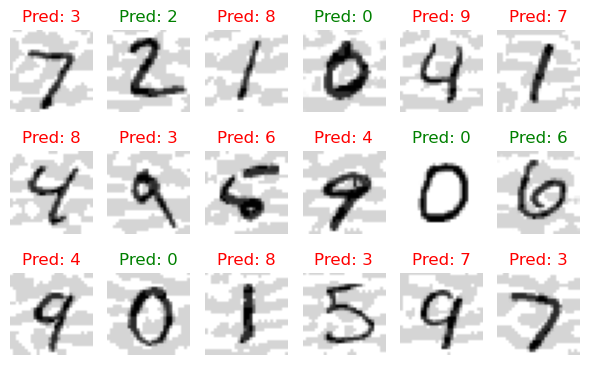

In [18]:
### Illustrate attacked images
delta = pgd(model_cnn, X, y, 0.1, 1e4, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)


In [19]:
delta = torch.zeros_like(X, requires_grad=True)
loss = nn.CrossEntropyLoss()(model_cnn(X + delta), y)
loss.backward()
print(delta.grad.abs().mean().item())


4.299217835068703e-06


In [20]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()


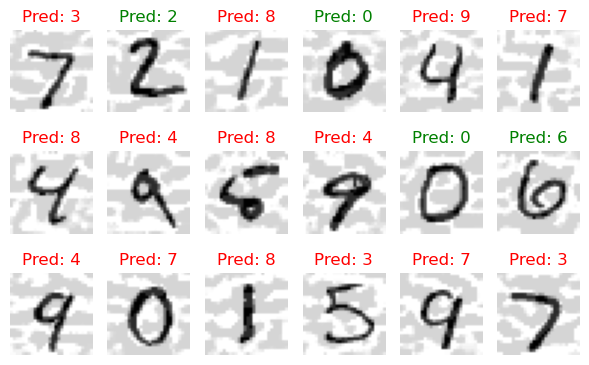

In [21]:
### Illustrate attacked images
delta = pgd_linf(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)


In [22]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])


2-layer DNN: 0.9551
4-layer DNN: 0.9877
CNN: 0.729


In [23]:
def pgd_linf_rand(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)
    
    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
        
        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta), y)
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()
        
        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
        
    return max_delta


In [24]:
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf_rand, 0.1, 1e-2, 40, 10)[0])


KeyboardInterrupt: 

In [ ]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()


In [ ]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=2)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)


In [ ]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)


In [ ]:
def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()


In [ ]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)


In [ ]:
def norms(Z):
    """Compute norms over all but the first dimension"""
    return Z.view(Z.shape[0], -1).norm(dim=1)[:,None,None,None]


def pgd_l2(model, X, y, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data += alpha*delta.grad.detach() / norms(delta.grad.detach())
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X) # clip X+delta to [0,1]
        delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon)
        delta.grad.zero_()
        
    return delta.detach()


In [ ]:
delta = pgd_l2(model_cnn, X, y, epsilon=2, alpha=0.1, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)


In [ ]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd_l2, 2, 0.1, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd_l2, 2, 0.1, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_l2, 2, 0.1, 40)[0])
